In [175]:
import pandas as pd
import numpy as np
from datetime import datetime
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from typing import Tuple
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, kruskal


#### Importing all sigwatch datasets

In [ ]:
df_2010 = pd.read_stata('sigwatch_data/2010_data_sigwatch.dta')
df_2011 = pd.read_stata('sigwatch_data/2011_data_sigwatch.dta')
df_2012 = pd.read_stata('sigwatch_data/2012_data_sigwatch.dta')
df_2013 = pd.read_stata('sigwatch_data/2013_data_sigwatch.dta')
df_2014 = pd.read_stata('sigwatch_data/2014_data_sigwatch.dta')
df_2015 = pd.read_stata('sigwatch_data/2015_data_sigwatch.dta')
df_2016 = pd.read_stata('sigwatch_data/2016_data_sigwatch.dta')
df_2017 = pd.read_stata('sigwatch_data/2017_data_sigwatch.dta')
df_2018 = pd.read_stata('sigwatch_data/2018_data_sigwatch.dta')


In [177]:
# Append all dataframes into one
df_combined = pd.concat([df_2010, df_2011, df_2012, df_2013, df_2014, df_2015, df_2016, df_2017, df_2018], ignore_index=True)

# Display basic information about the combined dataframe
print(f"Combined dataframe shape: {df_combined.shape}")
print(f"Total number of rows: {len(df_combined)}")
df_combined = df_combined.drop('link5', axis=1)

Combined dataframe shape: (73094, 94)
Total number of rows: 73094


#### Cleaning the merged dataset following example_name_cleaning.txt

In [178]:
import warnings
warnings.filterwarnings('ignore')
from sigwatch_pipeline import clean_sigwatch, filter_banks_us_uk_eu, sigwatch_summaries

cleaned = clean_sigwatch(df_combined)              # replicates the example_name_cleaning.txt logic
sigwatch_df   = filter_banks_us_uk_eu(cleaned)      # US/UK/EU banks only

s_clean = sigwatch_summaries(cleaned)
s_bank  = sigwatch_summaries(sigwatch_df)

#### Exploratory data analysis

In [179]:
df = sigwatch_df.copy()

In [180]:
print(f"Total number of campaign events: {df['uid_archive'].nunique():,}")
print(f"Number of unique firms targeted: {df['company'].nunique():,}")

# Breakdown by sentiment
sentiment_counts = df['sentiment'].value_counts().sort_index()
print("\nSentiment distribution:\n", sentiment_counts)

# Count positive vs negative campaigns
positive = df[df['sentiment'] > 0].shape[0]
negative = df[df['sentiment'] < 0].shape[0]
print(f"\nPositive campaigns: {positive}, Negative campaigns: {negative}")


Total number of campaign events: 1,049
Number of unique firms targeted: 324

Sentiment distribution:
 sentiment
-2.0    1186
-1.0    1123
Name: count, dtype: int64

Positive campaigns: 0, Negative campaigns: 2309


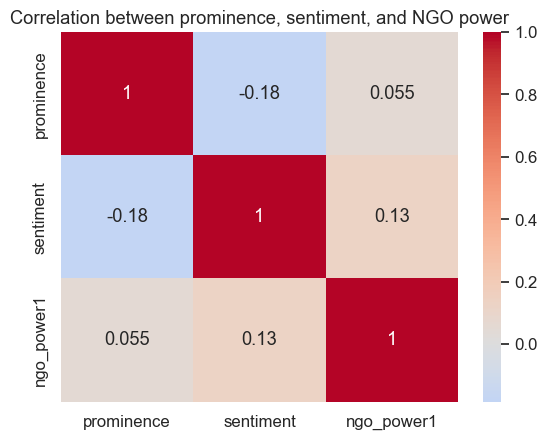

In [181]:
# Correlation between prominence, sentiment, and ngo_power (numeric)
cols = ['prominence', 'sentiment', 'ngo_power1']
df_corr = df[cols].corr()
sns.heatmap(df_corr, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation between prominence, sentiment, and NGO power")
plt.show()


The correlation matrix shows weak to moderate relationships among the three key qualitative indicators.
Sentiment and prominence are slightly negatively correlated, suggesting that highly critical messages (negative sentiment) tend to be less promotional and more subdued in placement.
NGO power shows almost no linear correlation with sentiment, meaning both small and large NGOs engage in positive and negative campaigns alike.
So, power and prominence act as independent dimensions in explaining how impactful a campaign might be.

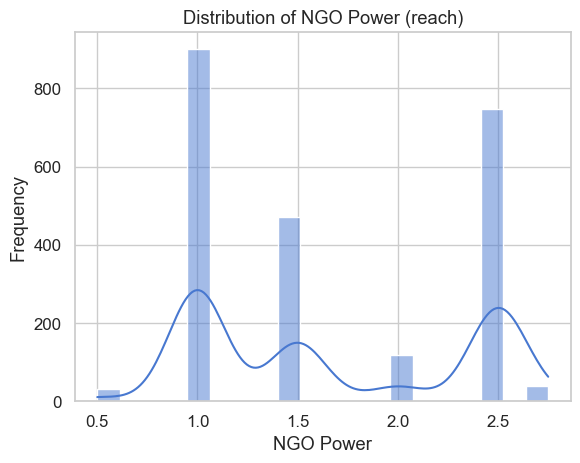

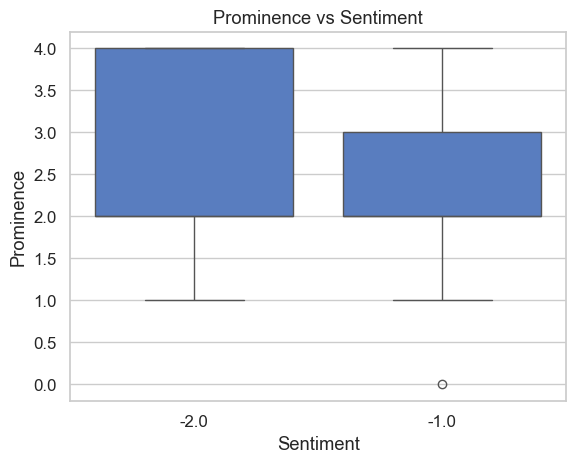

In [182]:
# NGO power distribution
sns.histplot(df['ngo_power1'], bins=20, kde=True)
plt.title("Distribution of NGO Power (reach)")
plt.xlabel("NGO Power")
plt.ylabel("Frequency")
plt.show()

# Prominence vs sentiment
sns.boxplot(x='sentiment', y='prominence', data=df)
plt.title("Prominence vs Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Prominence")
plt.show()


The barplot shows that most campaigns are led by NGOs with relatively low power or limited geographic reach since the highest frequency is around 1 on the scale. A smaller share of actions comes from global or transnational NGOs.
In the boxplot we see that very negative campaigns (sentiment = –2) tend to have higher prominence — they’re often mentioned in headlines or opening paragraphs, meaning these are high-profile critical actions. In contrast, moderately negative campaigns (sentiment = –1) show slightly lower prominence and more variation, indicating that less severe criticism may appear in background or supporting material.
Overall, the plot suggests that the harshest NGO messages tend to attract more attention.

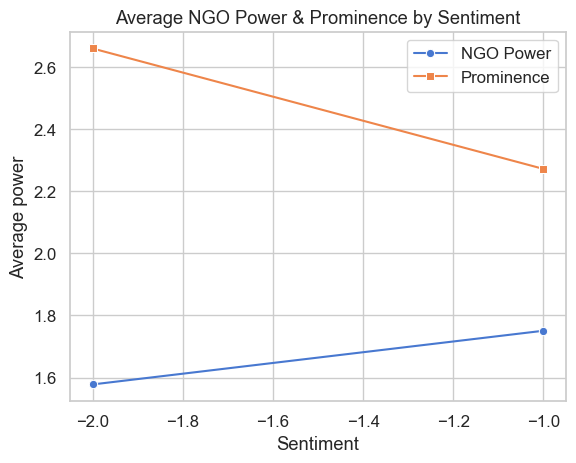

In [183]:
# Average NGO power by sentiment
avg_power = df.groupby('sentiment')['ngo_power1'].mean()
avg_prominence = df.groupby('sentiment')['prominence'].mean()

sns.lineplot(x=avg_power.index, y=avg_power.values, marker='o', label='NGO Power')
sns.lineplot(x=avg_prominence.index, y=avg_prominence.values, marker='s', label='Prominence')
plt.title("Average NGO Power & Prominence by Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Average power")
plt.legend()
plt.show()


This chart shows how NGO power and prominence vary with the tone of the campaign.
For very negative campaigns (–2), average prominence is noticeably higher — NGOs that strongly criticize companies tend to place these campaigns more visibly, often in headlines or early paragraphs.
At the same time, their average power (global reach) is slightly lower, indicating that smaller or regional NGOs are often the ones leading the harshest criticism.
As sentiment becomes less negative (–1), prominence decreases while NGO power rises modestly — suggesting that larger NGOs engage in more moderate campaigns, possibly aiming for dialogue or constructive pressure rather than confrontation.
Overall, the pattern hints at two contrasting activism styles:
* Local NGOs → highly critical but with limited reach.
* Larger NGOs → less aggressive but more globally influential.

# Day 2

#### Importing and merging the Datastream data

In [184]:
# Function to merge all sheets in an Excel file except the first one used for the price and return data
def merge_sheets(file_path):
    # Read all sheets (except the first)
    xls = pd.ExcelFile(file_path)
    sheet_names = xls.sheet_names[1:]

    # Read each sheet as a DataFrame
    dfs = [pd.read_excel(file_path, sheet_name=s) for s in sheet_names]

    # Merge them all on 'Name' (datetime column)
    from functools import reduce
    return reduce(lambda left, right: pd.merge(left, right, on='Name', how='outer'), dfs)

In [185]:
# Price indices and return indices dataframes
df_banks_pi = merge_sheets('banks_data_bocconi/banks_pi.xlsm')
df_banks_ri = merge_sheets('banks_data_bocconi/banks_ri.xlsm')
df_scandinavian_banks_pi = merge_sheets('banks_data_bocconi/scandinavian_banks_pi.xlsm')
df_scandinavian_banks_ri = merge_sheets('banks_data_bocconi/scandinavian_banks_ri.xlsm')

# Mergeing price indices and return indices dataframes
df_banks_pi = pd.merge(df_banks_pi, df_scandinavian_banks_pi, on='Name', how = 'inner')
df_banks_ri = pd.merge(df_banks_ri, df_scandinavian_banks_ri, on='Name', how = 'inner')

In [186]:
# Market excess return, risk-free rate and Fama-French factors dataframe
df_fff_eu = pd.read_excel('banks_data_bocconi/Europe_3_Factors_Daily.xlsx')
df_fff_us = pd.read_excel('banks_data_bocconi/North_America_3_Factors_Daily.xlsx')
df_fff = pd.merge(df_fff_eu, df_fff_us, on='date', how = 'inner', suffixes=('_eu', '_us'))

In [187]:
# US daily and monthly risk-free rate dataframes
df_us_rf_dd = pd.read_excel('banks_data_bocconi/risk_free_rate.xlsm', sheet_name='DAILY')
df_us_rf_mm = pd.read_excel('banks_data_bocconi/risk_free_rate.xlsm', sheet_name='MONTHLY')

In [188]:
# Banks information dataframe
df_banks_info = pd.concat(
    [pd.read_excel('banks_data_bocconi/banks_info.xlsx', sheet_name=s, usecols=lambda c: c in ["NAME","ISIN CODE","ISIN NUMBER","ISIN ISSUER CTRY"]) 
     for s in pd.ExcelFile('banks_data_bocconi/banks_info.xlsx').sheet_names[2:]],
    ignore_index=True)

In [189]:
# Final dataframe
df_banks_pi_ri = pd.merge(df_banks_pi, df_banks_ri, on='Name', how='inner')
df_fff['date'] = df_fff['date'].astype('datetime64[ns]')
df_banks = pd.merge(df_fff, df_banks_pi_ri, left_on='date', right_on='Name', how='inner')
df_banks = df_banks.drop(columns=['Name'])

# Task 4

We create two new data frames df_banks_us and df_banks_eu to estimate the Fama-French 5 factors model and be mindeful of different values for different markets.

In [190]:
df_fff_us_5 = pd.read_excel('F-F_Research_Data_5_Factors_2x3_daily.xlsx')

df_banks_us = pd.read_excel('banks_data_bocconi/banks_ri.xlsm', sheet_name= 'US')
df_fff_us_5['date'] = pd.to_datetime(df_fff_us_5['date'], format='%Y%m%d')
df_banks_us = pd.merge(df_fff_us_5, df_banks_us, left_on='date', right_on='Name', how='inner')
df_banks_us = df_banks_us.rename(columns={'Mkt-RF': 'Mkt-RF_us', 'SMB': 'SMB_us', 'HML': 'HML_us', 'RF': 'RF_us', 'RMW': 'RMW_us', 'CMA': 'CMA_us'})
df_banks_us = df_banks_us.drop(columns=['Name'])

tri_cols = df_banks_us.filter(like='TOT RETURN IND').columns

# Compute daily percentage returns for those columns
df_banks_us[tri_cols] = df_banks_us[tri_cols].pct_change()

# Remove the first row (since pct_change produces NaN there)
df_banks_us = df_banks_us.iloc[1:].reset_index(drop=True)

In [191]:
df_fff_eu_5 = pd.read_excel('Europe_5_Factors_Daily.xlsx')

df_banks_eu = df_banks_ri.drop(columns=df_banks_us.columns[7:].tolist())
df_fff_eu_5['date'] = pd.to_datetime(df_fff_eu_5['date'], format='%Y%m%d')
df_banks_eu = pd.merge(df_fff_eu_5, df_banks_eu, left_on='date', right_on='Name', how='inner')
df_banks_eu = df_banks_eu.rename(columns={'Mkt-RF': 'Mkt-RF_eu', 'SMB': 'SMB_eu', 'HML': 'HML_eu', 'RF': 'RF_eu', 'RMW': 'RMW_eu', 'CMA': 'CMA_eu'})
df_banks_eu = df_banks_eu.drop(columns=['Name'])

tri_cols = df_banks_eu.filter(like='TOT RETURN IND').columns

# Compute daily percentage returns for those columns
df_banks_eu[tri_cols] = df_banks_eu[tri_cols].pct_change() 

# Remove the first row (since pct_change produces NaN there)
df_banks_eu = df_banks_eu.iloc[1:].reset_index(drop=True)

### Estimating Fama-French 5 factors model 
(as well as CAPM & FF3)

#### EU

In [192]:
df_eu = df_banks_eu.copy()

# Use the first column as the Date index
date_col = df_eu.columns[0]
df_eu[date_col] = pd.to_datetime(df_eu[date_col])
df_eu = df_eu.set_index(date_col).sort_index()

# Identify columns
# Add the two extra FF5 factors (RMW & CMA)
required_factors = ['Mkt-RF_eu', 'SMB_eu', 'HML_eu', 'RMW_eu', 'CMA_eu', 'RF_eu']
missing = [c for c in required_factors if c not in df_eu.columns]
if missing:
    raise ValueError(f"Missing required factor columns: {missing}")

factor_cols = ['Mkt-RF_eu', 'SMB_eu', 'HML_eu', 'RMW_eu', 'CMA_eu', 'RF_eu']
stock_cols = [c for c in df_eu.columns if c not in factor_cols]

# Compute excess returns for all stocks
excess_returns = df_eu[stock_cols].subtract(df_eu['RF_eu'], axis=0)

# Build regressor matrices (add constant automatically)
X_capm = sm.add_constant(df_eu[['Mkt-RF_eu']])
X_ff3  = sm.add_constant(df_eu[['Mkt-RF_eu', 'SMB_eu', 'HML_eu']])
X_ff5  = sm.add_constant(df_eu[['Mkt-RF_eu', 'SMB_eu', 'HML_eu', 'RMW_eu', 'CMA_eu']])

def run_ols(y, X):
    # Align and drop NaNs per stock
    data = pd.concat([y, X], axis=1).dropna()
    if data.empty or data.shape[0] < data.shape[1]:  # rows <= params ⇒ not enough data
        return None

    Yi = data.iloc[:, 0]
    Xi = data.iloc[:, 1:]

    model = sm.OLS(Yi, Xi)  
    res = model.fit()
    return res

capm_rows = []
ff3_rows  = []
ff5_rows  = []

for stk in stock_cols:
    y = excess_returns[stk]

    # CAPM 
    res_c = run_ols(y, X_capm)
    if res_c is not None:
        capm_rows.append({
            "Stock": stk,
            "Alpha": res_c.params.get('const', np.nan),
            "Beta_Mkt": res_c.params.get('Mkt-RF_eu', np.nan),
            "t_Alpha": res_c.tvalues.get('const', np.nan),
            "t_Beta_Mkt": res_c.tvalues.get('Mkt-RF_eu', np.nan),
            "p_Alpha": res_c.pvalues.get('const', np.nan),
            "p_Beta_Mkt": res_c.pvalues.get('Mkt-RF_eu', np.nan),
            "R2": res_c.rsquared,
            "N": int(res_c.nobs)
        })

    # FF3
    res_f3 = run_ols(y, X_ff3)
    if res_f3 is not None:
        ff3_rows.append({
            "Stock": stk,
            "Alpha": res_f3.params.get('const', np.nan),
            "Beta_Mkt": res_f3.params.get('Mkt-RF_eu', np.nan),
            "Beta_SMB": res_f3.params.get('SMB_eu', np.nan),
            "Beta_HML": res_f3.params.get('HML_eu', np.nan),
            "t_Alpha": res_f3.tvalues.get('const', np.nan),
            "t_Beta_Mkt": res_f3.tvalues.get('Mkt-RF_eu', np.nan),
            "t_Beta_SMB": res_f3.tvalues.get('SMB_eu', np.nan),
            "t_Beta_HML": res_f3.tvalues.get('HML_eu', np.nan),
            "p_Alpha": res_f3.pvalues.get('const', np.nan),
            "p_Beta_Mkt": res_f3.pvalues.get('Mkt-RF_eu', np.nan),
            "p_Beta_SMB": res_f3.pvalues.get('SMB_eu', np.nan),
            "p_Beta_HML": res_f3.pvalues.get('HML_eu', np.nan),
            "R2": res_f3.rsquared,
            "N": int(res_f3.nobs)
        })

    # FF5
    res_f5 = run_ols(y, X_ff5)
    if res_f5 is not None:
        ff5_rows.append({
            "Stock": stk,
            "Alpha": res_f5.params.get('const', np.nan),
            "Beta_Mkt": res_f5.params.get('Mkt-RF_eu', np.nan),
            "Beta_SMB": res_f5.params.get('SMB_eu', np.nan),
            "Beta_HML": res_f5.params.get('HML_eu', np.nan),
            "Beta_RMW": res_f5.params.get('RMW_eu', np.nan),
            "Beta_CMA": res_f5.params.get('CMA_eu', np.nan),
            "t_Alpha": res_f5.tvalues.get('const', np.nan),
            "t_Beta_Mkt": res_f5.tvalues.get('Mkt-RF_eu', np.nan),
            "t_Beta_SMB": res_f5.tvalues.get('SMB_eu', np.nan),
            "t_Beta_HML": res_f5.tvalues.get('HML_eu', np.nan),
            "t_Beta_RMW": res_f5.tvalues.get('RMW_eu', np.nan),
            "t_Beta_CMA": res_f5.tvalues.get('CMA_eu', np.nan),
            "p_Alpha": res_f5.pvalues.get('const', np.nan),
            "p_Beta_Mkt": res_f5.pvalues.get('Mkt-RF_eu', np.nan),
            "p_Beta_SMB": res_f5.pvalues.get('SMB_eu', np.nan),
            "p_Beta_HML": res_f5.pvalues.get('HML_eu', np.nan),
            "p_Beta_RMW": res_f5.pvalues.get('RMW_eu', np.nan),
            "p_Beta_CMA": res_f5.pvalues.get('CMA_eu', np.nan),
            "R2": res_f5.rsquared,
            "N": int(res_f5.nobs)
        })

# DataFrames
capm_results_eu = pd.DataFrame(capm_rows).set_index("Stock").sort_index()
ff3_results_eu  = pd.DataFrame(ff3_rows).set_index("Stock").sort_index()
ff5_results_eu  = pd.DataFrame(ff5_rows).set_index("Stock").sort_index()

# Compare CAPM vs FF3 vs FF5 (Alpha & R²)
comparison_eu = (
    capm_results_eu[['Alpha','R2']].rename(columns={'Alpha':'Alpha_CAPM','R2':'R2_CAPM'})
    .join(
        ff3_results_eu[['Alpha','R2']].rename(columns={'Alpha':'Alpha_FF3','R2':'R2_FF3'}),
        how='outer'
    )
    .join(
        ff5_results_eu[['Alpha','R2']].rename(columns={'Alpha':'Alpha_FF5','R2':'R2_FF5'}),
        how='outer'
    )
)

#### US

In [193]:
df_us = df_banks_us.copy()

# Use the first column as the Date index
date_col = df_us.columns[0]
df_us[date_col] = pd.to_datetime(df_us[date_col])
df_us = df_us.set_index(date_col).sort_index()

# Identify columns (now including RMW & CMA)
required_factors = ['Mkt-RF_us', 'SMB_us', 'HML_us', 'RMW_us', 'CMA_us', 'RF_us']
missing = [c for c in required_factors if c not in df_us.columns]
if missing:
    raise ValueError(f"Missing required factor columns: {missing}")

factor_cols = ['Mkt-RF_us', 'SMB_us', 'HML_us', 'RMW_us', 'CMA_us', 'RF_us']
stock_cols = [c for c in df_us.columns if c not in factor_cols]

# Compute excess returns for all stocks
excess_returns = df_us[stock_cols].subtract(df_us['RF_us'], axis=0)

# Build regressor matrices (add constant automatically)
X_capm = sm.add_constant(df_us[['Mkt-RF_us']])
X_ff3  = sm.add_constant(df_us[['Mkt-RF_us', 'SMB_us', 'HML_us']])
X_ff5  = sm.add_constant(df_us[['Mkt-RF_us', 'SMB_us', 'HML_us', 'RMW_us', 'CMA_us']])

def run_ols(y, X):
    # Align and drop NaNs per stock
    data = pd.concat([y, X], axis=1).dropna()
    if data.empty or data.shape[0] < data.shape[1]:  # rows <= params ⇒ not enough data
        return None

    Yi = data.iloc[:, 0]
    Xi = data.iloc[:, 1:]

    model = sm.OLS(Yi, Xi)     
    res = model.fit()
    return res

capm_rows = []
ff3_rows  = []
ff5_rows  = []

for stk in stock_cols:
    y = excess_returns[stk]

    # CAPM 
    res_c = run_ols(y, X_capm)
    if res_c is not None:
        capm_rows.append({
            "Stock": stk,
            "Alpha": res_c.params.get('const', np.nan),
            "Beta_Mkt": res_c.params.get('Mkt-RF_us', np.nan),
            "t_Alpha": res_c.tvalues.get('const', np.nan),
            "t_Beta_Mkt": res_c.tvalues.get('Mkt-RF_us', np.nan),
            "p_Alpha": res_c.pvalues.get('const', np.nan),
            "p_Beta_Mkt": res_c.pvalues.get('Mkt-RF_us', np.nan),
            "R2": res_c.rsquared,
            "N": int(res_c.nobs)
        })

    # FF3 
    res_f3 = run_ols(y, X_ff3)
    if res_f3 is not None:
        ff3_rows.append({
            "Stock": stk,
            "Alpha": res_f3.params.get('const', np.nan),
            "Beta_Mkt": res_f3.params.get('Mkt-RF_us', np.nan),
            "Beta_SMB": res_f3.params.get('SMB_us', np.nan),
            "Beta_HML": res_f3.params.get('HML_us', np.nan),
            "t_Alpha": res_f3.tvalues.get('const', np.nan),
            "t_Beta_Mkt": res_f3.tvalues.get('Mkt-RF_us', np.nan),
            "t_Beta_SMB": res_f3.tvalues.get('SMB_us', np.nan),
            "t_Beta_HML": res_f3.tvalues.get('HML_us', np.nan),
            "p_Alpha": res_f3.pvalues.get('const', np.nan),
            "p_Beta_Mkt": res_f3.pvalues.get('Mkt-RF_us', np.nan),
            "p_Beta_SMB": res_f3.pvalues.get('SMB_us', np.nan),
            "p_Beta_HML": res_f3.pvalues.get('HML_us', np.nan),
            "R2": res_f3.rsquared,
            "N": int(res_f3.nobs)
        })

    # FF5 
    res_f5 = run_ols(y, X_ff5)
    if res_f5 is not None:
        ff5_rows.append({
            "Stock": stk,
            "Alpha": res_f5.params.get('const', np.nan),
            "Beta_Mkt": res_f5.params.get('Mkt-RF_us', np.nan),
            "Beta_SMB": res_f5.params.get('SMB_us', np.nan),
            "Beta_HML": res_f5.params.get('HML_us', np.nan),
            "Beta_RMW": res_f5.params.get('RMW_us', np.nan),
            "Beta_CMA": res_f5.params.get('CMA_us', np.nan),
            "t_Alpha": res_f5.tvalues.get('const', np.nan),
            "t_Beta_Mkt": res_f5.tvalues.get('Mkt-RF_us', np.nan),
            "t_Beta_SMB": res_f5.tvalues.get('SMB_us', np.nan),
            "t_Beta_HML": res_f5.tvalues.get('HML_us', np.nan),
            "t_Beta_RMW": res_f5.tvalues.get('RMW_us', np.nan),
            "t_Beta_CMA": res_f5.tvalues.get('CMA_us', np.nan),
            "p_Alpha": res_f5.pvalues.get('const', np.nan),
            "p_Beta_Mkt": res_f5.pvalues.get('Mkt-RF_us', np.nan),
            "p_Beta_SMB": res_f5.pvalues.get('SMB_us', np.nan),
            "p_Beta_HML": res_f5.pvalues.get('HML_us', np.nan),
            "p_Beta_RMW": res_f5.pvalues.get('RMW_us', np.nan),
            "p_Beta_CMA": res_f5.pvalues.get('CMA_us', np.nan),
            "R2": res_f5.rsquared,
            "N": int(res_f5.nobs)
        })

# DataFrames
capm_results_us = pd.DataFrame(capm_rows).set_index("Stock").sort_index()
ff3_results_us  = pd.DataFrame(ff3_rows).set_index("Stock").sort_index()
ff5_results_us  = pd.DataFrame(ff5_rows).set_index("Stock").sort_index()

# Compare CAPM vs FF3 vs FF5 (Alpha & R²)
comparison_us = (
    capm_results_us[['Alpha','R2']].rename(columns={'Alpha':'Alpha_CAPM','R2':'R2_CAPM'})
    .join(
        ff3_results_us[['Alpha','R2']].rename(columns={'Alpha':'Alpha_FF3','R2':'R2_FF3'}),
        how='outer'
    )
    .join(
        ff5_results_us[['Alpha','R2']].rename(columns={'Alpha':'Alpha_FF5','R2':'R2_FF5'}),
        how='outer'
    )
)

# Task 5

#### Computing abnormal returns using Fama-French 5 factors model

In [194]:
df_eu = df_banks_eu.copy()
df_eu.set_index(df_eu.columns[0], inplace=True)

# Factors and stocks
factors = df_eu[['Mkt-RF_eu', 'SMB_eu', 'HML_eu', 'RMW_eu', 'CMA_eu', 'RF_eu']]
stocks  = df_eu.drop(columns=factors.columns)

# Compute expected returns using FF5 estimated parameters
expected_returns_dict = {}

for stock in stocks.columns:
    if stock not in ff5_results_eu.index:
        continue  
    params = ff5_results_eu.loc[stock]
    expected_returns_dict[stock] = (
        factors['RF_eu']
        + params['Alpha']
        + params['Beta_Mkt'] * factors['Mkt-RF_eu']
        + params['Beta_SMB'] * factors['SMB_eu']
        + params['Beta_HML'] * factors['HML_eu']
        + params['Beta_RMW'] * factors['RMW_eu']
        + params['Beta_CMA'] * factors['CMA_eu']
    )

expected_returns = pd.DataFrame(expected_returns_dict, index=factors.index)

# Abnormal returns = actual - expected
abnormal_returns_eu = stocks[expected_returns.columns] - expected_returns

In [195]:
df_us = df_banks_us.copy()
df_us.set_index(df_us.columns[0], inplace=True)

# Factors and stocks
factors = df_us[['Mkt-RF_us', 'SMB_us', 'HML_us', 'RMW_us', 'CMA_us', 'RF_us']]
stocks  = df_us.drop(columns=factors.columns)

# Expected returns using FF5 estimates
expected_returns_dict = {}

for stock in stocks.columns:
    if stock not in ff5_results_us.index:
        continue  
    params = ff5_results_us.loc[stock]
    expected_returns_dict[stock] = (
        factors['RF_us']
        + params['Alpha']
        + params['Beta_Mkt'] * factors['Mkt-RF_us']
        + params['Beta_SMB'] * factors['SMB_us']
        + params['Beta_HML'] * factors['HML_us']
        + params['Beta_RMW'] * factors['RMW_us']
        + params['Beta_CMA'] * factors['CMA_us']
    )

expected_returns = pd.DataFrame(expected_returns_dict, index=factors.index)
abnormal_returns_us = stocks[expected_returns.columns] - expected_returns

In [196]:
abnormal_returns = pd.merge(abnormal_returns_eu, abnormal_returns_us, on='date', how='inner')
abnormal_returns = abnormal_returns.reset_index()

#### Mapping the companies in the Sigwatch dataframe to the companies in the abnormal returns dataframe

In [197]:
import pandas as pd, re, unicodedata
from rapidfuzz import process, fuzz

# Text normalization, simplifies both lists before comparing
def strip_accents(s):
    return ''.join(c for c in unicodedata.normalize('NFKD', s) if not unicodedata.combining(c))

def normalize(s):
    if not isinstance(s, str): return ''
    s = strip_accents(s.lower())
    s = re.sub(r'[-–]', ' ', s)
    s = re.sub(r'\bdead\b.*$', '', s)
    s = re.sub(r'tot return ind.*', '', s)
    s = re.sub(r'[^\w\s]', ' ', s)
    s = re.sub(r'\b(se|sa|spa|plc|llp|llc|inc|ltd|nv|ag|oyj|ab|asa|holdings?|group|banking|ord|pref|npv|r|a|b|n|pf|sr)\b','',s)
    s = re.sub(r'\s+', ' ', s).strip()
    return s

bank_names_ds = list(abnormal_returns.columns)
bank_names_sw = list(sigwatch_df['company'].unique())

# Normalize both lists once
norm1 = [normalize(x) for x in bank_names_ds]
norm2 = [normalize(x) for x in bank_names_sw]

# Build lookup for recovery of original return df company names
lookup1 = dict(zip(norm1, bank_names_ds))

# Performs matching
matches = {}
threshold = 88  # can be finetuned (85–90 often works best)
for raw2, n2 in zip(bank_names_sw, norm2):
    best = process.extractOne(n2, norm1, scorer=fuzz.token_set_ratio)
    if best and best[1] >= threshold:
        best_norm1, score, _ = best
        matches[raw2] = lookup1[best_norm1]   # map sigwatch_df original to abnormal_returns original

df_matches = pd.DataFrame(matches.items(), columns=['sigwatch_df_name', 'matched_abnormal_returns'])
print(f"Matched {len(df_matches)} out of {len(bank_names_sw)} sigwatch_df companies.")

Matched 61 out of 324 sigwatch_df companies.


In [198]:
final_dict = matches

# Keeps only rows whose company names exist in the mapping
sigwatch_df = sigwatch_df[sigwatch_df['company'].isin(final_dict.keys())].copy()

# Replaces names according to the mapping
sigwatch_df['company'] = sigwatch_df['company'].map(final_dict)

#### Computing CARs

For each event in sigwatch_df, the function aligns the event date with the same trading day (or the next available trading day if the date is not in the market calendar), constructs an event window around that date, and computes cumulative abnormal returns over three periods: car_total for the full window, car_pre for the pre-event window, car_post for the post-event window. 

The function returns two outputs:
* ar_panel a cleaned version of the abnormal returns dataset that includes only the companies that appear in both the event list and the abnormal return data, with all trading dates sorted chronologically.
* cars table that contains one row per event. It preserves all original event-level information from sigwatch_df and adds new columns with the CARs the total CAR over the full event window, the pre-event CAR, and the post-event CAR. In addition, it includes extra data for each event, such as the aligned trading date (event_date_aligned), the actual start and end of the event window (window_start and window_end), whether the window was clipped because of limited data, and the number of observations used, missing-value counts, and window coverage ratio. 

It can safely handle partial windows for events that occur near the start or end of the dataset and allows control over how much missing data is acceptable before an event is excluded.


In [199]:
def prepare_and_compute_cars(
    sigwatch_df: pd.DataFrame,
    abnormal_returns: pd.DataFrame,
    pre: int = 10,
    post: int = 10,
    max_missing: int = 0,          # absolute max NaNs allowed inside the (observed) window
    allow_partial_windows: bool = False,
    min_obs_ratio: float = 1.0,    # required observed fraction of FULL window (after NaNs); e.g. 0.8 when allowing partials
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    
    sigwatch = sigwatch_df.copy()
    sigwatch['date'] = pd.to_datetime(sigwatch['date']).dt.normalize()
    if 'sentiment' in sigwatch.columns:
        sigwatch['sentiment'] = pd.to_numeric(sigwatch['sentiment'], errors='coerce')

    ar = abnormal_returns.copy()
    ar['date'] = pd.to_datetime(ar['date']).dt.normalize()

    # Overlapping firms
    firms_from_events = set(sigwatch['company'].unique())
    firms_in_ar = set(ar.columns) - {'date'}
    keep = sorted(firms_from_events & firms_in_ar)
    if not keep:
        raise ValueError("No overlapping companies between sigwatch_df.company and abnormal_returns columns.")

    ar_panel = ar[['date'] + keep].sort_values('date').reset_index(drop=True)
    trade_dates = ar_panel['date'].to_numpy()  

    def index_same_or_next(dt: pd.Timestamp):
        # Return index for same trading day if available, else next trading day (T+)
        idx = np.searchsorted(trade_dates, np.datetime64(dt), side='left')
        if idx >= len(trade_dates):
            return None
        return idx

    rows = []
    expected_full_len = pre + post + 1

    for sw_row in sigwatch.itertuples(index=False, name='SW'):
        sw = sw_row._asdict()
        company = sw.get('company')
        evt_date = sw.get('date')

        if company not in keep:
            continue

        t0 = index_same_or_next(evt_date)
        if t0 is None:
            # no later trading day in sample
            continue

        aligned_date = pd.Timestamp(trade_dates[t0])
        rolled_forward = aligned_date != evt_date

        # Ideal (unclipped) bounds
        lo_ideal = t0 - pre
        hi_ideal = t0 + post

        # Handle clipping rules
        if not allow_partial_windows:
            # Must fit entirely
            if lo_ideal < 0 or hi_ideal >= len(trade_dates):
                continue
            lo_eff, hi_eff = lo_ideal, hi_ideal
            window_clipped = False
        else:
            # Clip to available sample
            lo_eff = max(0, lo_ideal)
            hi_eff = min(len(trade_dates) - 1, hi_ideal)
            window_clipped = (lo_eff != lo_ideal) or (hi_eff != hi_ideal)

        # If the effective window is empty 
        if hi_eff < lo_eff:
            continue

        # Series for this firm in the effective window
        window_series = ar_panel.iloc[lo_eff:hi_eff+1][company]
        n_missing = int(window_series.isna().sum())
        actual_len = int(hi_eff - lo_eff + 1)
        observed_obs = actual_len - n_missing

        # Missingness cap
        if n_missing > max_missing:
            continue

        # Coverage requirement measured vs full intended length 
        coverage_ratio = observed_obs / expected_full_len
        if coverage_ratio < min_obs_ratio:
            continue

        # Compute CARs with safe pre/post slicing on the effective window
        pre_lo = max(lo_eff, t0 - pre)
        pre_hi = min(hi_eff, t0 - 1)
        if pre_hi >= pre_lo:
            pre_slice = ar_panel.iloc[pre_lo:pre_hi+1][company]
            car_pre = float(pre_slice.sum(skipna=True))
            pre_obs = int(pre_slice.shape[0] - pre_slice.isna().sum())
        else:
            car_pre = 0.0
            pre_obs = 0

        # Post: [0, +post] -> indices [t0, t0+post]
        post_lo = max(lo_eff, t0)
        post_hi = min(hi_eff, t0 + post)
        if post_hi >= post_lo:
            post_slice = ar_panel.iloc[post_lo:post_hi+1][company]
            car_post = float(post_slice.sum(skipna=True))
            post_obs = int(post_slice.shape[0] - post_slice.isna().sum())
        else:
            car_post = 0.0
            post_obs = 0

        # Total over [-pre, +post] on the effective window (clipped if partial)
        car_total = float(window_series.sum(skipna=True))

        out = dict(sw)  # keep ALL original event columns
        out.update({
            'event_date_original': pd.Timestamp(evt_date),
            'event_date_aligned': aligned_date,
            'aligned_rolled_forward': bool(rolled_forward),

            'window_start': pd.Timestamp(trade_dates[lo_eff]),
            'window_end': pd.Timestamp(trade_dates[hi_eff]),
            'window_clipped': bool(window_clipped),

            'pre': int(pre),
            'post': int(post),

            'car': car_total,   # over effective window, within [-pre, +post]
            'car_pre': car_pre,       # [-pre, -1] intersect effective window
            'car_post': car_post,     # [0, +post] intersect effective window

            'observed_obs': int(observed_obs),            # non-NaN obs in effective window
            'actual_window_len': int(actual_len),         # effective length (clipped or full)
            'expected_window_len': int(expected_full_len),# intended full length
            'n_missing_in_window': int(n_missing),
        })
        rows.append(out)

    cars = pd.DataFrame(rows).sort_values(['company', 'event_date_aligned']).reset_index(drop=True)
    return ar_panel, cars

def summarize_cars(cars: pd.DataFrame) -> pd.DataFrame:
    return (
        cars.groupby('company', as_index=False)
            .agg(
                events=('car', 'size'),
                mean_car=('car', 'mean'),
                median_car=('car', 'median'),
                mean_car_pre=('car', 'mean'),
                mean_car_post=('car', 'mean')
            )
            .sort_values('mean_car', ascending=False)
    )

We select the baseline [-10, +10] window.

In [200]:
ar_panel, cars = prepare_and_compute_cars(sigwatch_df, abnormal_returns, pre=10, post=10)
cars_by_company = summarize_cars(cars)

# Task 6

To see whether NGO campaigns that  expose corporate malpractice generate measurable market reactions, we conduct a series of statistical tests on firms’ cumulative abnormal returns (CARs) around the campaign announcements. 

The first set of one-sample tests evaluates whether the average CAR across all events differs significantly from zero, testing the null hypothesis that firms experience no abnormal performance following NGO exposure. This analysis provides initial evidence on whether, on average, investors reward or penalize targeted firms. 

To further explore changes in firm performance relative to the exposure event, we conduct paired tests comparing pre- and post-event CARs. The paired t-test and Wilcoxon signed-rank test jointly assess whether post-event abnormal returns differ from pre-event returns, allowing us to determine whether NGO campaigns produce a significant shift in market valuation. Overall, the analyses test whether NGO campaigns lead to measurable changes in firm value through their short-term impact on stock prices.

#### Do campaigns move returns?

In [201]:
def onesample_tests(series, name='CAR'):
    s = series.dropna()
    n = len(s)
    mean, std = s.mean(), s.std(ddof=1)
    # t-test of mean != 0
    tstat, p_t = stats.ttest_1samp(s, popmean=0.0, alternative='two-sided')
    # Nonparametric (robust to heavy tails)
    # Wilcoxon requires nonzero values
    try:
        wstat, p_w = stats.wilcoxon(s, zero_method='wilcox', alternative='two-sided')
    except ValueError:
        wstat, p_w = np.nan, np.nan
    return pd.Series({
        'n': n, 'mean': mean, 'std': std,
        'tstat(=0)': tstat, 'p_t': p_t,
        'wilcoxon': wstat, 'p_w': p_w
    }, name=name)

overall = onesample_tests(cars['car'])
overall

n            1.132000e+03
mean         6.866628e-03
std          1.028140e-01
tstat(=0)    2.247058e+00
p_t          2.482853e-02
wilcoxon     2.519410e+05
p_w          4.259494e-10
Name: CAR, dtype: float64

The sample consists of 1,132 cumulative abnormal returns (CARs) with an average value of approximately +0.69%. Both statistical tests suggest that the CARs are significantly different from zero. The mean CAR of +0.69% suggests that, on average, firms experienced a small but positive abnormal return following NGO exposure events.
* The t-test (p = 0.0248) indicates that the mean CAR differs significantly from zero at the 5% significance level. This means that, assuming approximate normality and independent observations, we can reject the null hypothesis of “no abnormal performance.”
* The Wilcoxon signed-rank test (p = 4.26×10⁻¹⁰) provides even stronger evidence that the median CAR is not zero. Because the Wilcoxon test is nonparametric, this result is robust even if the CAR distribution is skewed or heavy-tailed.

There is statistically significant evidence that the average cumulative abnormal return (CAR) is positive and different from zero. The effect is small in magnitude (≈0.7%), but highly significant statistically, especially under the Wilcoxon test.

Contrary to what might be expected, NGO campaigns did not trigger negative market reactions on average. Instead, the evidence points to a slight positive market response, suggesting that:
* Investors may view NGO campaigns as opportunities for firms to improve transparency, mitigate reputational risk, or strengthen ESG credentials rather than purely as negative shocks.
* Alternatively, the market may interpret the exposures as non-material to firm value on average, with heterogeneity across firms (some strongly penalized, others unaffected or rewarded).

Next we will look at pre-and post-event CARs.

#### Pre- vs. Post-event CAR

In [202]:
paired = cars[['car_pre','car_post']].dropna()

# Paired t-test
tstat, p_t = stats.ttest_rel(paired['car_post'], paired['car_pre'])

# Wilcoxon signed-rank (non-parametric)
wstat, p_w = stats.wilcoxon(paired['car_post'] - paired['car_pre'])

pd.Series({
    'n': len(paired),
    'mean_pre': paired['car_pre'].mean(),
    'mean_post': paired['car_post'].mean(),
    'mean_diff': (paired['car_post'] - paired['car_pre']).mean(),
    'tstat_post-pre': tstat, 'p_t': p_t,
    'wilcoxon': wstat, 'p_w': p_w
})

n                   1132.000000
mean_pre               0.004652
mean_post              0.002215
mean_diff             -0.002437
tstat_post-pre        -1.407578
p_t                    0.159531
wilcoxon          302713.000000
p_w                    0.103237
dtype: float64

The average CAR decreased slightly after the NGO campaign (from +0.47% to +0.22%), but the change is small and statistically insignificant.
* The paired t-test (p = 0.16) indicates that we cannot reject the null hypothesis that the mean pre- and post-CARs are equal.
* The Wilcoxon signed-rank test (p = 0.10) similarly finds no statistically significant median difference, confirming the result is robust even without assuming normality.

Overall, the evidence suggests that NGO campaigns did not lead to a change in firms’ cumulative abnormal returns. While the average post-campaign CAR is marginally lower than the pre-campaign CAR (−0.24 percentage points), this difference is not statistically meaningful.

This implies that the market reaction does not significantly worsen after NGO exposure. Investors may perceive the campaigns as having limited financial relevance, or the effects could vary widely across firms, offsetting in the aggregate. The lack of significance could also reflect anticipation effects (markets already pricing in reputational risks) or campaign credibility or visibility.

## Appendix: Further exploratory analysis

##### Before/after COP21

In [203]:
cars_test = cars.dropna(subset=['car', 'sentiment']).copy()
cars_test['post_COP21'] = (cars_test['event_date_aligned'] >= pd.Timestamp('2015-12-11')).astype(int)

# One-sample t-tests of CAR = 0
overall_t = stats.ttest_1samp(cars_test['car'], popmean=0.0, nan_policy='omit')

pre = cars_test.loc[cars_test['post_COP21'] == 0, 'car']
post = cars_test.loc[cars_test['post_COP21'] == 1, 'car']
pre_t  = stats.ttest_1samp(pre,  0.0, nan_policy='omit') if len(pre)  else None
post_t = stats.ttest_1samp(post, 0.0, nan_policy='omit') if len(post) else None

print("\n One-Sample t-Tests")
print(f"Overall:     t = {overall_t.statistic:.3f}, p = {overall_t.pvalue:.4f}")
if pre_t:
    print(f"Pre-COP21:   t = {pre_t.statistic:.3f}, p = {pre_t.pvalue:.4f}")
else:
    print("Pre-COP21:   No data available.")
if post_t:
    print(f"Post-COP21:  t = {post_t.statistic:.3f}, p = {post_t.pvalue:.4f}")
else:
    print("Post-COP21:  No data available.")

# Correlation between CAR and numeric sentiment
pearson_r, pearson_p = stats.pearsonr(cars_test['sentiment'], cars_test['car'])
spearman_r, spearman_p = stats.spearmanr(cars_test['sentiment'], cars_test['car'])

print("\n Correlations (CAR vs. Sentiment)")
print(f"Pearson:     r = {pearson_r:.3f}, p = {pearson_p:.4f}")
print(f"Spearman:    r = {spearman_r:.3f}, p = {spearman_p:.4f}")


 One-Sample t-Tests
Overall:     t = 2.247, p = 0.0248
Pre-COP21:   t = 17.775, p = 0.0000
Post-COP21:  t = -6.397, p = 0.0000

 Correlations (CAR vs. Sentiment)
Pearson:     r = 0.123, p = 0.0000
Spearman:    r = 0.098, p = 0.0010


Before COP21, CARs are strongly positive (t = 17.78, p < 0.001), implying that campaigns were associated with value increases for targeted firms. After COP21, the average CAR turns significantly negative (t = –6.40, p < 0.001), suggesting a reversal in market reactions—campaigns after COP21 were followed by value declines, perhaps reflecting growing investor sensitivity to sustainability pressures.

The correlations between CAR and sentiment are positive and statistically significant, though modest in magnitude (Pearson r = 0.12; Spearman ρ = 0.10). This indicates that, on average, more positive campaign sentiment is associated with slightly higher CARs. In other words, when NGO messaging or market perception of the campaign is more favorable, the stock price response tends to be less negative (or more positive).

##### OLS: CAR ~ sentiment + prominence + post_COP21 + sentiment:post_COP21

In [204]:
# OLS: CAR ~ sentiment + prominence + post_COP21 + sentiment:post_COP21  (robust SE)
model1 = smf.ols('car ~ sentiment + prominence + post_COP21 + sentiment:post_COP21', data=cars_test).fit(cov_type='HC1')
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:                    car   R-squared:                       0.187
Model:                            OLS   Adj. R-squared:                  0.184
Method:                 Least Squares   F-statistic:                     62.67
Date:                Wed, 29 Oct 2025   Prob (F-statistic):           7.32e-48
Time:                        21:24:12   Log-Likelihood:                 1086.3
No. Observations:                1132   AIC:                            -2163.
Df Residuals:                    1127   BIC:                            -2137.
Df Model:                           4                                         
Covariance Type:                  HC1                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.0632 

The regression results suggest that several factors significantly influence firms’ cumulative abnormal returns (CARs) around NGO campaign events. 
* The positive and significant intercept (0.063, p < 0.001) indicates that, on average, campaigns are associated with positive abnormal returns when sentiment and prominence are at their baseline levels. 
* The coefficient for prominence is negative and highly significant (–0.010, p < 0.001), suggesting that more prominent campaigns tend to generate lower CARs, possibly because high-profile actions draw stronger negative investor reactions. 
* The sentiment coefficient is slightly negative before COP21 (–0.009, p = 0.099), implying that sentiment alone had little or mildly adverse effect pre-COP21. However, the strong and positive interaction between sentiment and post-COP21 (0.053, p < 0.001) shows that after COP21, more positive sentiment campaigns led to notably higher CARs. 

Overall, the model explains about 18.7% of CAR variation (R² = 0.187), indicating that campaign characteristics—especially prominence and sentiment after COP21—help explain how markets respond to NGO actions.

##### Which campaigns move returns more? (group splits)

In [205]:
df = cars.copy()
df['sentiment_bucket'] = pd.cut(df['sentiment'], bins=[-3, -1.5, 0],labels=['very_neg','neg'])
df['prom_high'] = (df['prominence'] >= 3).astype(int) 
df['company_type'] = df.get('company_type', pd.Series(index=df.index)).fillna('unknown')

def grouped_onesample(df, group):
    out = []
    for k, g in df.groupby(group, dropna=False):
        out.append(onesample_tests(g['car'], name=str(k)))
    return pd.DataFrame(out)

# Sentiment buckets (very_neg, neg)
sent_tests = grouped_onesample(df,'sentiment_bucket')

# Prominence high vs low
prom_tests = grouped_onesample(df, 'prom_high')

# Company type (parent/subsidiary/brand/unknown)
ctype_tests = grouped_onesample(df, 'company_type')

sent_tests, prom_tests, ctype_tests

(              n      mean       std  tstat(=0)           p_t  wilcoxon  \
 very_neg  651.0 -0.003978  0.110630  -0.917518  3.592118e-01   98235.0   
 neg       481.0  0.021544  0.089209   5.296662  1.799696e-07   33639.0   
 
                    p_w  
 very_neg  1.007766e-01  
 neg       1.533788e-15  ,
        n      mean       std  tstat(=0)       p_t  wilcoxon           p_w
 0  709.0  0.007008  0.101228   1.843304  0.065702   98654.0  6.210142e-07
 1  423.0  0.006630  0.105540   1.292055  0.197045   35428.0  1.838384e-04,
                  n      mean       std  tstat(=0)       p_t  wilcoxon  \
 Parent      1092.0  0.006475  0.103313   2.070917  0.038601  234815.0   
 Subsidiary    40.0  0.017572  0.088557   1.254919  0.216976     298.0   
 
                      p_w  
 Parent      1.069273e-09  
 Subsidiary  1.350838e-01  )

The results show clear differences in how markets react to campaigns depending on sentiment, prominence, and company type. 
* Campaigns with negative sentiment (mean CAR = 0.0215, p < 0.001) generate significantly positive abnormal returns, while very negative campaign (mean CAR = –0.0040, p = 0.36) show no significant effect. This suggests that the market reacts more favorably—or at least less negatively—when campaign sentiment is moderately negative rather than strongly hostile. 
* Comparing prominence, both low- and high-prominence campaigns yield small, statistically insignificant average CARs in t-tests, although the Wilcoxon results indicate that their distributions still differ from zero, implying more nuanced or asymmetric reactions. 
* By company type, only parent companies experience a significantly positive mean CAR (0.0065, p = 0.039), while subsidiaries show no significant effect. 

Overall, these findings suggest that market responses are shaped by the tone and visibility of campaigns and are primarily concentrated among parent firms.

##### Windowsize = [-5, +5]

In [206]:
ar_panel5, cars5 = prepare_and_compute_cars(sigwatch_df, abnormal_returns, pre=5, post=5)

In [207]:
overall5 = onesample_tests(cars5['car'])
overall5

n            1.132000e+03
mean         4.325890e-03
std          6.099396e-02
tstat(=0)    2.386227e+00
p_t          1.718593e-02
wilcoxon     2.641630e+05
p_w          2.846941e-07
Name: CAR, dtype: float64

In [208]:
paired = cars5[['car_pre','car_post']].dropna()

# Paired t-test
tstat, p_t = stats.ttest_rel(paired['car_post'], paired['car_pre'])

# Wilcoxon signed-rank (non-parametric)
wstat, p_w = stats.wilcoxon(paired['car_post'] - paired['car_pre'])

pd.Series({
    'n': len(paired),
    'mean_pre': paired['car_pre'].mean(),
    'mean_post': paired['car_post'].mean(),
    'mean_diff': (paired['car_post'] - paired['car_pre']).mean(),
    'tstat_post-pre': tstat, 'p_t': p_t,
    'wilcoxon': wstat, 'p_w': p_w
})

n                   1132.000000
mean_pre               0.002791
mean_post              0.001535
mean_diff             -0.001255
tstat_post-pre        -0.942223
p_t                    0.346280
wilcoxon          308174.000000
p_w                    0.257219
dtype: float64

From the results of the tests above, we may draw the same conclusions when using a smaller window size such as [-5, +5].

# Task 7

In [209]:
# We use the entire dataset for task 7. Using the entire dataset ensures that the analysis captures the complete range of variation across all observations, reducing the potential for sampling bias.
sigwatch_df = df_combined.copy()


#### Country Name Standardization

We normalize `company_parent_country` to minimize merge failures later (e.g., *United States* → *USA*).  
Add more mappings if your data includes variants.


In [210]:
if 'company_parent_country' not in sigwatch_df.columns:
    raise KeyError("Column 'company_parent_country' not found. Inspect your schema.")

sigwatch_df['company_parent_country'] = sigwatch_df['company_parent_country'].astype(str).str.strip()

country_map = {
    'United States': 'USA',
    'United States of America': 'USA',
    'U.S.A.': 'USA',
    'United Kingdom': 'UK',
    'Great Britain': 'UK',
    'Russian Federation': 'Russia',
}
sigwatch_df['company_parent_country'] = sigwatch_df['company_parent_country'].replace(country_map)

print("Sample parent countries:", sigwatch_df['company_parent_country'].dropna().unique()[:12])

Sample parent countries: ['US' 'Germany' 'Sweden' 'Switzerland' 'Italy' 'Brazil' 'Indonesia'
 'Spain' 'Canada' 'France' 'Japan' 'Malaysia']



#### Environmental Campaign Detector (`is_environmental`)

**Goal:** Flag campaigns whose issue(s) are environmental.  
**Why robust?** We:
- Detect likely **issue columns** dynamically (`issue_name1/2/3` or `issue1/2/3`).  
- Use **word-boundary regex** (so “coal” doesn't match “coalition”).  
- Handle **NaNs** and avoid false positives.


In [211]:
# Detect issue columns robustly 
issue_cols = []
for c in sigwatch_df.columns:
    c_stripped = c.strip()
    if re.match(r'(?i)^issue(_?name)?[123]$', c_stripped):
        issue_cols.append(c)

# Fallback: try common names explicitly
if not issue_cols:
    for cand in ['issue_name1','issue_name2','issue_name3','issue1','issue2','issue3']:
        if cand in sigwatch_df.columns:
            issue_cols.append(cand)

if not issue_cols:
    raise ValueError("No issue columns found (e.g., issue_name1/2/3). Verify schema.")

# Curated environmental keywords 
env_keywords = [
    "climate", "global warming", "decarbon", "carbon", "co2", "emission", "net zero",
    "pollution", "air quality", "water quality", "waste", "plastic",
    "oil", "gas", "coal", "fossil", "pipeline", "mining",
    "biodiversity", "deforestation", "forestry", "habitat", "conservation",
    "renewable", "wind", "solar", "hydro", "geothermal", "biofuel", "sustainable forestry",
    "environment", "ecosystem", "marine", "ocean", "fishery", "toxic", "pesticide", "chemical spill"
]

# Word-boundary regex with suffix tolerance (e.g., 'emission(s)')
pattern = r'\b(' + '|'.join(re.escape(k) for k in env_keywords) + r')\w*\b'
pat = re.compile(pattern, flags=re.IGNORECASE)

def _to_text(x):
    if pd.isna(x):
        return ""
    return str(x)

# Convert issue columns to clean text
issue_text = sigwatch_df[issue_cols].applymap(_to_text)

# Row is environmental if ANY issue column matches the pattern
is_env_mask = issue_text.apply(lambda col: col.str.contains(pat, na=False), axis=0).any(axis=1)

sigwatch_df['is_environmental'] = is_env_mask.astype(int)

print("Environmental flagged:", int(sigwatch_df['is_environmental'].sum()), "/", len(sigwatch_df))
print("Environmental share:", round(sigwatch_df['is_environmental'].mean(), 3))

Environmental flagged: 34464 / 73094
Environmental share: 0.472


#### Subset: Environmental Campaigns Only (`env_df`)

We filter on `is_environmental == 1` and ensure `sentiment` is numeric for analysis.


In [212]:
env_df = sigwatch_df[sigwatch_df['is_environmental'] == 1].copy()
print("env_df shape:", env_df.shape)

if 'sentiment' not in env_df.columns:
    raise KeyError("Column 'sentiment' not found. Check Sigwatch schema.")

env_df['sentiment'] = pd.to_numeric(env_df['sentiment'], errors='coerce')
print("Sentiment summary (environmental only):")
print(env_df['sentiment'].describe())

env_df shape: (34464, 94)
Sentiment summary (environmental only):
count    34464.000000
mean        -1.196060
std          1.157882
min         -2.000000
25%         -2.000000
50%         -2.000000
75%         -1.000000
max          2.000000
Name: sentiment, dtype: float64



#### Simulated Green Index Dataset (with political categories)

To keep the notebook **self-contained**, we **simulate** a realistic `green_df`:
- `green_index`: approximate % votes for Green parties (2019 EU elections).
- `green_category`: classification thresholds  
  - Green-oriented: > 12%  
  - Neutral: 6–12%  
  - Conservative: < 6%


In [213]:
# Simulate a realistic Green Index dataset
green_df = pd.DataFrame({
    'country': [
        'Germany', 'France', 'Italy', 'Poland',
        'Netherlands', 'UK', 'Spain', 'Sweden',
        'Finland', 'Norway'
    ],
    'green_index': [20.5, 13.5, 2.3, 1.2, 10.0, 11.8, 7.4, 11.5, 16.0, 14.5]
})

def classify_green(v):
    if v > 12:
        return 'Green-oriented'
    elif v >= 6:
        return 'Neutral'
    else:
        return 'Conservative'

green_df['green_category'] = green_df['green_index'].apply(classify_green)

print("Simulated Green Index (preview):")
print(green_df.head(10))

Simulated Green Index (preview):
       country  green_index  green_category
0      Germany         20.5  Green-oriented
1       France         13.5  Green-oriented
2        Italy          2.3    Conservative
3       Poland          1.2    Conservative
4  Netherlands         10.0         Neutral
5           UK         11.8         Neutral
6        Spain          7.4         Neutral
7       Sweden         11.5         Neutral
8      Finland         16.0  Green-oriented
9       Norway         14.5  Green-oriented



#### Merge Political Orientation into `env_df`

We merge using `company_parent_country` (home of the targeted company).  


In [214]:
# Normalize country names like before to reduce mismatches
name_map = {
    'United States': 'USA',
    'United States of America': 'USA',
    'U.S.A.': 'USA',
    'United Kingdom': 'UK',
    'Great Britain': 'UK',
    'Russian Federation': 'Russia',
}
green_df['country'] = green_df['country'].replace(name_map)

# Merge
env_df = env_df.merge(
    green_df[['country','green_index','green_category']],
    how='left',
    left_on='company_parent_country',
    right_on='country'
)

coverage = env_df['green_category'].notna().mean()
print(f"Rows in env_df with a political category: {coverage:.2%}")
print(env_df[['company_parent_country','green_index','green_category']].drop_duplicates().head(10))

Rows in env_df with a political category: 33.61%
   company_parent_country  green_index  green_category
0                      US          NaN             NaN
2               Indonesia          NaN             NaN
4             Switzerland          NaN             NaN
8                   Spain          7.4         Neutral
10                 Canada          NaN             NaN
11               Malaysia          NaN             NaN
13                Germany         20.5  Green-oriented
14            Netherlands         10.0         Neutral
15                 Sweden         11.5         Neutral
16                 Norway         14.5  Green-oriented


In [215]:
env_df['green_category'] = env_df['green_category'].fillna('Unknown')
env_plot = env_df[env_df['green_category'].isin(['Green-oriented','Neutral','Conservative'])].copy()


#### Country-level Summary

We aggregate per `company_parent_country`:
- `n_campaigns`: total environmental campaign events (2010–2018)
- `avg_sentiment`: average sentiment score
- `positive_share`: fraction of campaigns with `sentiment > 0`

We then re-attach `green_index` and `green_category` for interpretation.


In [216]:
cc = env_df.groupby('company_parent_country')

summary = pd.DataFrame({
    'n_campaigns': cc.size(),
    'avg_sentiment': cc['sentiment'].mean(),
    'positive_share': cc['sentiment'].apply(lambda s: (s > 0).mean())
}).reset_index()

summary = summary.merge(
    green_df[['country','green_index','green_category']],
    how='left', left_on='company_parent_country', right_on='country'
)

#### Correlation: Green Index vs Number of Environmental Campaigns

**Question:** Do greener countries (higher GreenIndex) see more NGO environmental campaigns?  
We compute **Pearson’s r** and plot a simple regression line.

Pearson r = 0.393, p = 0.2607, N = 10


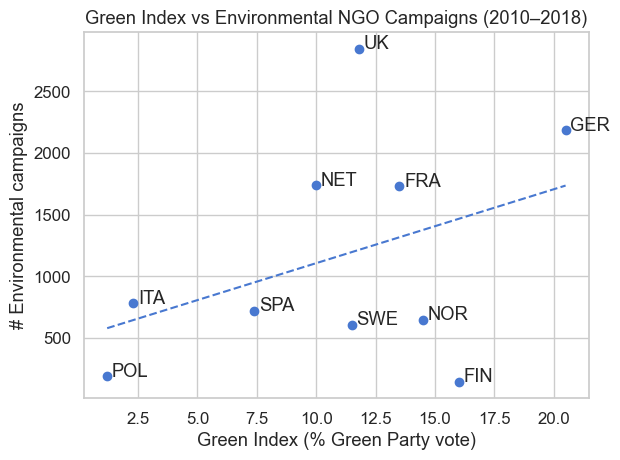

In [217]:
corr_df = summary.dropna(subset=['green_index', 'n_campaigns'])

if len(corr_df) >= 3:
    r, p = pearsonr(corr_df['green_index'], corr_df['n_campaigns'])
    print(f"Pearson r = {r:.3f}, p = {p:.4f}, N = {len(corr_df)}")
else:
    print("Not enough countries with green_index for correlation (need ≥ 3).")

# Plot (matplotlib only)
plt.figure()
plt.scatter(corr_df['green_index'], corr_df['n_campaigns'])

# Regression line
m, b = np.polyfit(corr_df['green_index'], corr_df['n_campaigns'], 1)
x = np.linspace(corr_df['green_index'].min(), corr_df['green_index'].max(), 100)
plt.plot(x, m*x + b, linestyle='--')

# Annotate short country labels
for _, row in corr_df.iterrows():
    label = (row['company_parent_country'] or '')[:3].upper()
    plt.text(row['green_index']+0.2, row['n_campaigns']+0.2, label)

plt.title("Green Index vs Environmental NGO Campaigns (2010–2018)")
plt.xlabel("Green Index (% Green Party vote)")
plt.ylabel("# Environmental campaigns")
plt.tight_layout()
plt.show()


#### Sentiment Differences by Political Category (Kruskal–Wallis)

**Why Kruskal–Wallis?** Sentiment is **discrete** (-2…+2) and usually **non-normal**.  
KW tests if the distributions across categories (**Green-oriented / Neutral / Conservative**) differ.

We validate group sizes and then plot:
- **Boxplot** of sentiment distributions (matplotlib).
- **Bar chart** of positive campaign share.


Group sizes: {'Green-oriented': 4706, 'Neutral': 5908, 'Conservative': 968}
Kruskal–Wallis across ['Green-oriented', 'Neutral', 'Conservative'] -> H = 38.12, p = 0.0000


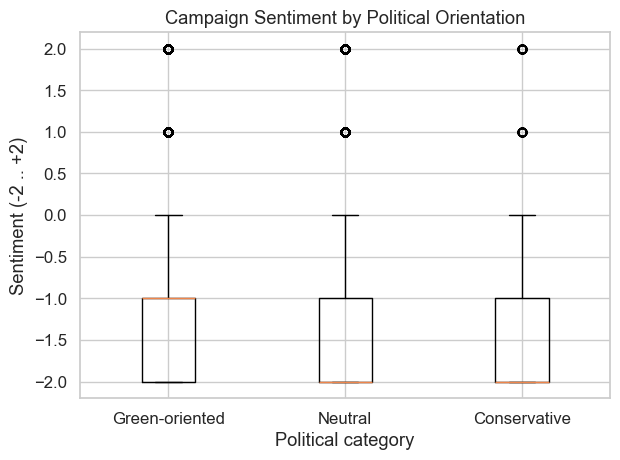

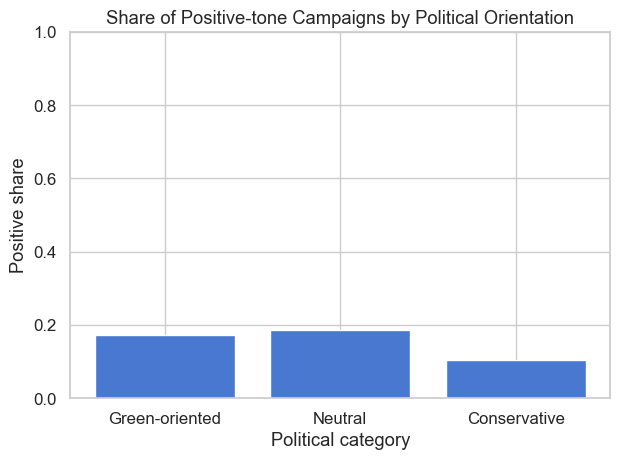

In [218]:
env_df_kruskal = env_df.dropna(subset=['green_category','sentiment']).copy()

cats = ['Green-oriented','Neutral','Conservative']
groups = []
labels = []
for c in cats:
    g = env_df_kruskal.loc[env_df_kruskal['green_category'] == c, 'sentiment']
    if len(g) > 0:
        groups.append(g)
        labels.append(c)

print("Group sizes:", {lab: len(g) for lab, g in zip(labels, groups)})
if len(groups) < 2:
    print("Not enough groups with data to run Kruskal–Wallis. Check merges/categories.")
else:
    H, p_value = kruskal(*groups)
    print(f"Kruskal–Wallis across {labels} -> H = {H:.2f}, p = {p_value:.4f}")

# Boxplot (matplotlib)
order = labels
data_for_plot = [env_df_kruskal.loc[env_df_kruskal['green_category'] == c, 'sentiment'] for c in order]

plt.figure()
plt.boxplot(data_for_plot, labels=order, showfliers=True)
plt.title("Campaign Sentiment by Political Orientation")
plt.xlabel("Political category")
plt.ylabel("Sentiment (-2 .. +2)")
plt.tight_layout()
plt.show()

# Positive share per category (bar chart)
pos_share = (env_df_kruskal.assign(pos=(env_df_kruskal['sentiment']>0).astype(int))
             .groupby('green_category')['pos'].mean()
             .reindex(order))

plt.figure()
plt.bar(pos_share.index, pos_share.values)
plt.title("Share of Positive-tone Campaigns by Political Orientation")
plt.xlabel("Political category")
plt.ylabel("Positive share")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

In [219]:
df = env_df.dropna(subset=['green_category','sentiment']).copy()
df['green_category'] = df['green_category'].astype(str).str.strip()
df['sentiment'] = pd.to_numeric(df['sentiment'], errors='coerce')

print(df['sentiment'].value_counts().sort_index())     
print(df['green_category'].value_counts(dropna=False)) 
print(sorted(df['green_category'].unique()))

sentiment
-2    18946
-1     9666
 0     1375
 1     2617
 2     1860
Name: count, dtype: int64
green_category
Unknown           22882
Neutral            5908
Green-oriented     4706
Conservative        968
Name: count, dtype: int64
['Conservative', 'Green-oriented', 'Neutral', 'Unknown']



#### Temporal Trends (2010–2018) by Political Category

We count environmental campaigns per **year × category** and plot lines.  
This helps show whether gaps persist or widen over time across political contexts.


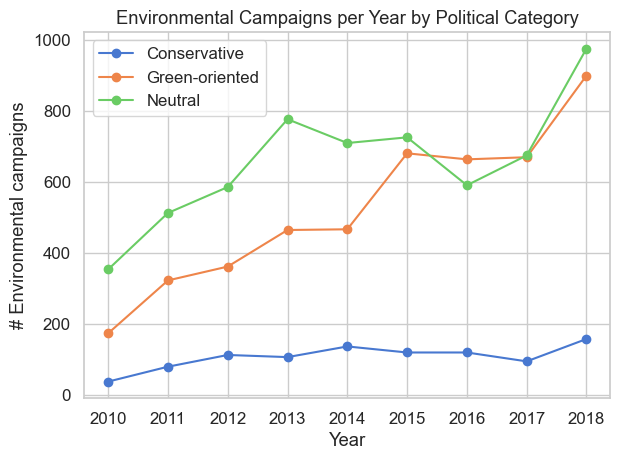

In [220]:
env_df['date'] = pd.to_datetime(env_df['date'])
env_df['year'] = env_df['date'].dt.year

# Drop the "Unknown" rows (case/space safe)
mask = env_df['green_category'].astype(str).str.strip().str.lower().ne('unknown')
env_df = env_df[mask]

trend_df = (
    env_df.dropna(subset=['green_category'])
          .groupby(['year','green_category'])
          .size()
          .reset_index(name='n_campaigns')
)

env_df['date'] = pd.to_datetime(env_df['date'])
env_df['year'] = env_df['date'].dt.year
trend_df = env_df.dropna(subset=['green_category']).groupby(['year','green_category']).size().reset_index(name='n_campaigns')

if trend_df.empty:
    print("No data for temporal trends (missing categories after merge).")
else:
    plt.figure()
    for cat in trend_df['green_category'].dropna().unique():
        sub = trend_df[trend_df['green_category']==cat].sort_values('year')
        plt.plot(sub['year'], sub['n_campaigns'], marker='o', label=cat)
    plt.title("Environmental Campaigns per Year by Political Category")
    plt.xlabel("Year")
    plt.ylabel("# Environmental campaigns")
    plt.legend()
    plt.tight_layout()
    plt.show()